In [69]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import skfuzzy as fz
from skfuzzy import control as ctrl


#Setup variables for universe and their ranges
#Input with respect to object
distance = ctrl.Antecedent(np.arange(0, 10, 0.5), 'distance')
angle    = ctrl.Antecedent(np.arange(0, 90, 1), 'angle')

#Resulting action to take
speed = ctrl.Consequent(np.arange(0, 5, 0.2), 'speed')
steer  = ctrl.Consequent(np.arange(0, 90, 1), 'steer')



  


/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


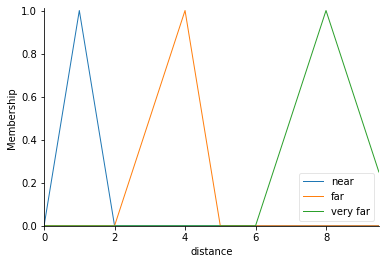

In [70]:

#Set up custom memberships for each variable and output
distance['near'] = fz.trimf(distance.universe, [0, 1, 2]) 
distance['far'] = fz.trimf(distance.universe,  [2, 4, 5]) 
distance['very far'] = fz.trimf(distance.universe,  [6, 8, 10])

#seems to be broken outside of using this in ipython. *smh*
distance.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


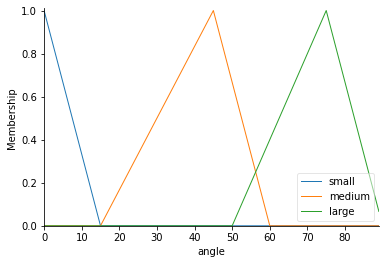

In [71]:

#Set up custom memberships for each variable and output
angle["small"] = fz.trimf(angle.universe, [0, 0, 15]) 
angle["medium"] = fz.trimf(angle.universe,  [15, 45, 60]) 
angle["large"] = fz.trimf(angle.universe,  [50, 75, 90])

#seems to be broken outside of using this in ipython.
angle.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


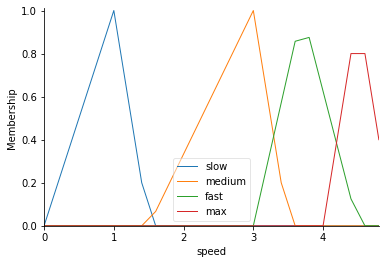

In [72]:

#Set up custom memberships for each variable and output
speed['slow'] = fz.trimf(speed.universe, [0, 1, 1.5]) 
speed['medium'] = fz.trimf(speed.universe,  [1.5, 3, 3.5]) 
speed['fast'] = fz.trimf(speed.universe,  [3, 3.7, 4.5])
speed['max'] = fz.trimf(speed.universe,  [4, 4.5, 5])

#seems to be broken outside of using this in ipython.
speed.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


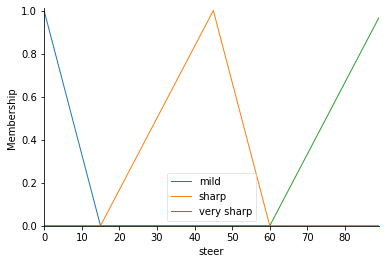

In [73]:
#Set up custom memberships for each variable and output
steer['mild'] = fz.trimf(steer.universe, [0, 0, 15]) 
steer['sharp'] = fz.trimf(steer.universe,  [15, 45, 60]) 
steer['very sharp'] = fz.trimf(steer.universe,  [60, 90, 90])


#seems to be broken outside of using this in ipython.
steer.view()

In [77]:
rule1 = ctrl.Rule(distance['near'] & angle['large'], steer['mild'])
rule2 = ctrl.Rule(distance['near'] & angle['large'], speed['fast'])

rule3 = ctrl.Rule(distance['near'] & angle['medium'], steer['sharp'])
rule4 = ctrl.Rule(distance['near'] & angle['medium'], speed['medium'])

rule5 = ctrl.Rule(distance['near'] & angle['small'], steer['very sharp'])
rule6 = ctrl.Rule(distance['near'] & angle['small'], speed['slow'])


rule7  = ctrl.Rule(distance['far'] & angle['large'], steer['mild'])
rule8  = ctrl.Rule(distance['far'] & angle['large'], speed['fast'])

rule9  = ctrl.Rule(distance['far'] & angle['medium'], steer['sharp'])
rule10 = ctrl.Rule(distance['far'] & angle['medium'], speed['medium'])

rule11 = ctrl.Rule(distance['far'] & angle['small'], steer['sharp'])
rule12 = ctrl.Rule(distance['far'] & angle['small'], speed['medium'])


rule13  = ctrl.Rule(distance['very far'] & angle['large'], steer['mild'])
rule14  = ctrl.Rule(distance['very far'] & angle['large'], speed['max'])

rule15  = ctrl.Rule(distance['very far'] & angle['medium'], steer['mild'])
rule16 = ctrl.Rule(distance['very far'] & angle['medium'], speed['fast'])

rule17 = ctrl.Rule(distance['very far'] & angle['small'], steer['mild'])
rule18 = ctrl.Rule(distance['very far'] & angle['small'], speed['medium'])



#rule1.view()
#rule2.view()
#rule3.view()
#rule4.view()